In [1]:
import io
import os
import re
import sys
import csv
import gzip
import glob
import time
import secrets
import multiprocessing
import subprocess
import resource
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from plotnine import *
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


# Work in different catagories

In [10]:
# See this url for a documentation on more information on the array https://www.thermofisher.com/document-connect/document-connect.html?url=https://assets.thermofisher.com/TFS-Assets%2FLSG%2Fbrochures%2FGGNO07706-2_DS_Axiom_PMRA.pdf

db = sqlite3.connect("data/chip/Axiom_PMRA.na36.r1.a1.annot.db")
X = pd.read_sql_query("SELECT * FROM Annotations", db)
X['Associated_Gene'] = X['Associated_Gene'].str.split(' // ').str.get(-1)
X['Heterozygous_Allele_Frequencies'] = X['Heterozygous_Allele_Frequencies'].str.split(' /// ').str.get(-1).str.split(' // ').str.get(0)
X['Minor_Allele_Frequency'] = X['Minor_Allele_Frequency'].str.split(' /// ').str.get(-1).str.split(' // ').str.get(0)
X = X.drop(columns = ['ProbeSet_ID', 'Affy_SNP_ID', 'Strand', 'Stop',
                      'dbSNP_Loctype', 'In_Hapmap', 'Strand_Vs_dbSNP', 'Probe_Count',
                     'ChrX_PAR', 'Cytoband', 'Flank', 'Allele_A', 'Allele_B', 'Genetic_Map',
                     'Microsatellite', 'Allele_Frequency_Count', 'ClinVar_OMIM_Phenotype',
                     'ClinVar_OMIM_Description', 'ClinVar_MIM', 'EBI_PUBMEDID',
                     'EBI_MAPPED_GENE', 'EBI_SNPS', 'EBI_SNP_ID_CURRENT', 'EBI_MAPPED_TRAIT',
                     'EBI_MAPPED_TRAIT_URI', 'Allele_Frequencies', 'Minor_Allele', 'Ordered_Alleles',
                     'Annotation_Notes', 'extended_rsid', 'ClinVar_VariantID', 'Biomedical', 'ClinVar_RSID'])
X = X.rename(columns = {'Chr_id': 'chr', 'Start': 'pos', 'dbSNP_RS_ID': 'ID', 'Ref_Allele': 'ref', 'Alt_Allele': 'alt'})
X = X[X['chr'].astype(str).isin(CHROMOSOMES_ALL)]
X = X.sort_values(by = ['chr', 'pos'], ascending = True)
clin_cols = ['OMIM', 'ClinVar_ClinicalSignificance', 'ClinVar_GeneSymbol', 'ClinVar_Traits', 'ClinVar_OMIM_Gene']
for i in clin_cols:
    X[i] = X[i].astype(str)
X = X[~X[clin_cols].eq("None").all(axis=1)]
X

chr         pos           ID ref alt  \
162238    1   1005429.0   rs58913475   -   A   
682670    1   1005721.0  rs114443588   G   T   
595637    1   1011483.0  rs183136696   A   C   
682671    1   1012429.0  rs115074115   G   C   
506500    1   1014143.0  rs786201005   C   T   
...     ...         ...          ...  ..  ..   
901812   22  50744726.0  rs762191835   G   -   
703609   22  50747104.0  rs115392965   C   T   
291819   22  50749396.0  rs141612488   C   T   
785709   22  50749854.0   rs28420908   G   A   
703610   22  50749890.0  rs117000254   T   G   

                               Associated_Gene  \
162238  hes family bHLH transcription factor 4   
682670  hes family bHLH transcription factor 4   
595637  hes family bHLH transcription factor 4   
682671  hes family bHLH transcription factor 4   
506500           ISG15 ubiquitin-like modifier   
...                                        ...   
901812                                 acrosin   
703609    ribosomal protein L23a pseudogene 82   
291819    ribosomal protein L23a pseudogene 82   
785709    ribosomal protein L23a pseudogene 82   
703610    ribosomal protein L23a pseudogene 82   

       Heterozygous_Allele_Frequencies Minor_Allele_Frequency  \
162238                          0.4722                 0.2731   
682670                          0.1852                 0.1111   
595637                          0.0556                 0.0278   
682671                          0.0000                 0.0000   
506500                            None                   None   
...                                ...                    ...   
901812                            None                   None   
703609                          0.1111                 0.0556   
291819                          0.2037                 0.1204   
785709                          0.1944                 0.0972   
703610                          0.0278                 0.0139   

                                                     OMIM  Allele_Count  \
162238  147571 // Immunodeficiency 38 // 616126 // int...           2.0   
682670  147571 // Immunodeficiency 38 // 616126 // int...           2.0   
595637  147571 // Immunodeficiency 38 // 616126 // int...           2.0   
682671  147571 // Immunodeficiency 38 // 616126 // int...           2.0   
506500  147571 // Immunodeficiency 38 // 616126 // non...           2.0   
...                                                   ...           ...   
901812  102480 // ?Male infertility due to acrosin def...           2.0   
703609  102480 // ?Male infertility due to acrosin def...           2.0   
291819  102480 // ?Male infertility due to acrosin def...           2.0   
785709  102480 // ?Male infertility due to acrosin def...           2.0   
703610  102480 // ?Male infertility due to acrosin def...           2.0   

       ClinVar_ClinicalSignificance ClinVar_GeneSymbol  \
162238                         None               None   
682670                         None               None   
595637                         None               None   
682671                         None               None   
506500                   PATHOGENIC              ISG15   
...                             ...                ...   
901812                         None               None   
703609                         None               None   
291819                         None               None   
785709                         None               None   
703610                         None               None   

                                           ClinVar_Traits ClinVar_OMIM_Gene  \
162238                                               None              None   
682670                                               None              None   
595637                                               None              None   
682671                                               None              None   
506500  IMMUNODEFICIENCY 38 WITH BASAL GANGLIA CALCIFI..

In [75]:
keywords = ['anemia', 'blood', 'Eryth']
keywords = '|'.join(keywords)

Y = X[X['OMIM'].str.contains(keywords, case=False, na=False)]

In [76]:
runs = ['lc_oneKG--chip--typed', 'lc_oneKG--hc--snps_gw', 'lc_oneKG_topmed--hc--snps_gw']
impaccs = []

for r in runs:
    h = [pd.read_csv('results/imputation_comparison/vanilla/' + r + '/impacc/all_samples/by_variant/chr' + str(i) + '.h.tsv', sep = '\t') for i in CHROMOSOMES_ALL]
    h = pd.concat(h)
    h = h[h['r2'] != -9]
    gwas = pd.merge(h, Y, on = ['chr', 'pos'])
    h_impacc = lcwgsus.generate_h_impacc(gwas)
    impaccs.append(h_impacc)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

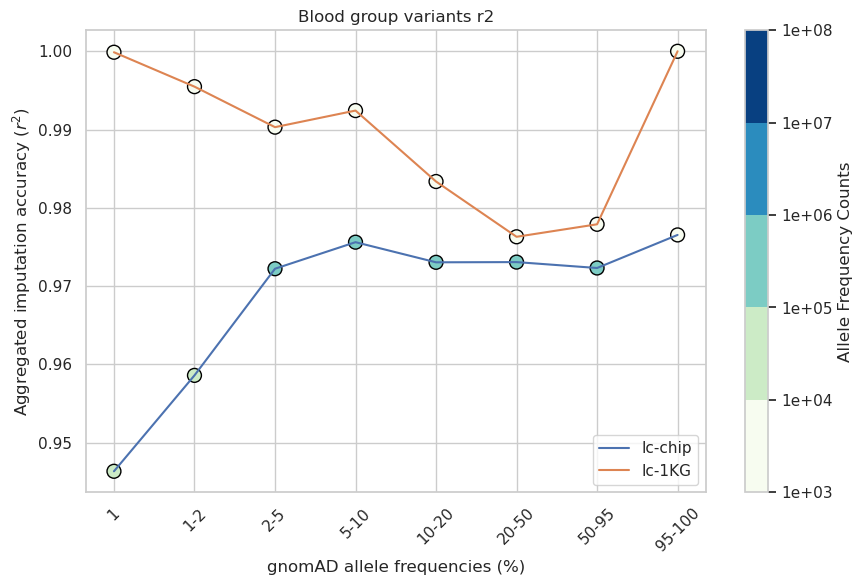

In [77]:
# impaccs[0].loc[[0,2], 'r2'] = 0
# impaccs[1].loc[0, 'r2'] = 0
# impaccs[2].loc[0, 'r2'] = 0

dfs = impaccs
labels = ['lc-chip', 'lc-1KG', 'lc-1KG-TOPMed']
title = 'Blood group variants r2'

# lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

In [78]:
bad = pd.read_csv('results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/all_r2less0.5.tsv', sep = '\t')
merged = pd.merge(X, bad, on = ['chr', 'pos']).drop_duplicates()
merged

chr         pos           ID ref_x alt_x  \
0       1   1045444.0         None     G     C   
2       1   2254781.0   rs16824948     C     T   
3       1   3226751.0  rs114172340     G     A   
4       1   3444841.0  rs144140363     G     A   
5       1   3446243.0   rs80336315     A     G   
...   ...         ...          ...   ...   ...   
1167   22  40463302.0   rs73422615     G     A   
1168   22  45550014.0  rs114090291     G     A   
1169   22  45590634.0   rs77622670     G     T   
1170   22  45618766.0  rs116431142     A     G   
1171   22  50714126.0    rs9616948     A     G   

                                  Associated_Gene  \
0                                           agrin   
2                              SKI proto-oncogene   
3                         PR domain containing 16   
4                         PR domain containing 16   
5                         PR domain containing 16   
...                                           ...   
1167  megakaryoblastic leukemia (translocation) 1   
1168                                    fibulin 1   
1169                                    fibulin 1   
1170  long intergenic non-protein coding RNA 1589   
1171    SH3 and multiple ankyrin repeat domains 3   

     Heterozygous_Allele_Frequencies Minor_Allele_Frequency  \
0                             0.2037                 0.1111   
2                             0.0000                 0.0000   
3                             0.1574                 0.0787   
4                             0.0000                 0.0000   
5                             0.0000                 0.0000   
...                              ...                    ...   
1167                          0.1759                 0.0972   
1168                          0.0463                 0.0231   
1169                          0.0093                 0.0046   
1170                          0.0556                 0.0278   
1171                          0.0000                 0.0000   

                                                   OMIM  Allele_Count  \
0     103320 // Myasthenic syndrome, congenital, 8, ...           2.0   
2     164780 // Shprintzen-Goldberg syndrome // 1822...           2.0   
3     605557 // Left ventricular noncompaction 8 // ...           2.0   
4     605557 // Left ventricular noncompaction 8 // ...           2.0   
5     605557 // Left ventricular noncompaction 8 // ...           2.0   
...                                                 ...           ...   
1167  606078 // Megakaryoblastic leukemia, acute // ...           2.0   
1168  135820 // Synpolydactyly, 3/3'4, associated wi...           2.0   
1169  135820 // Synpolydactyly, 3/3'4, associated wi...           2.0   
1170  611150 // Spinocerebellar ataxia 10 // 603516 ...           2.0   
1171  606230 // Phelan-McDermid syndrome // 606232 /...           2.0   

     ClinVar_ClinicalSignificance ClinVar_GeneSymbol ClinVar_Traits  \
0               LIKELY PATHOGENIC               AGRN   NOT PROVIDED   
2                            None               None           None   
3                            None               None           None   
4                            None               None           None   
5                            None               None           None   
...                           ...                ...            ...   
1167                         None               None           None   
1168                         None               None           None   
1169                         None               None           None   
1170                         None               None           None   
1171                         None               None           None   

     ClinVar_OMIM_Gene EBI_DISEASE_TRAIT ref_y alt_y       MAF        r2  
0                 None              None     G     C  0.056306  0.363030  
2                 None              None     C     T  0.011081  0.497019  
3                 None              None     G     A  0.

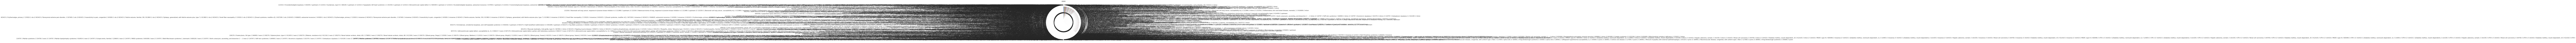

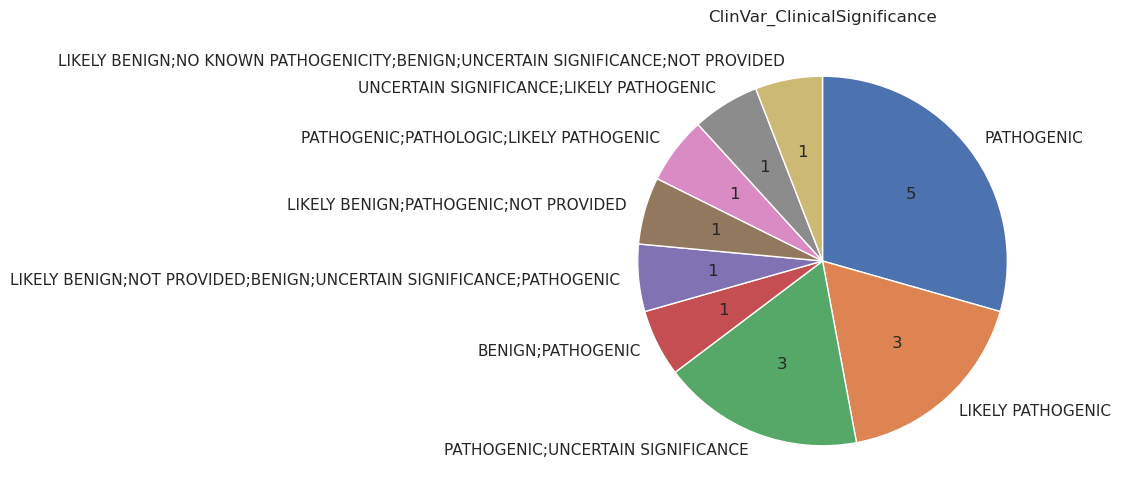

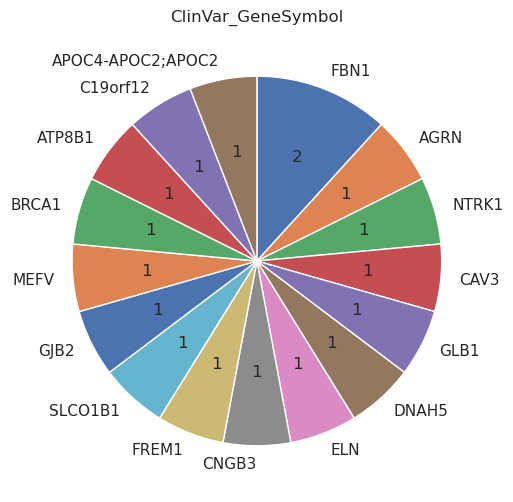

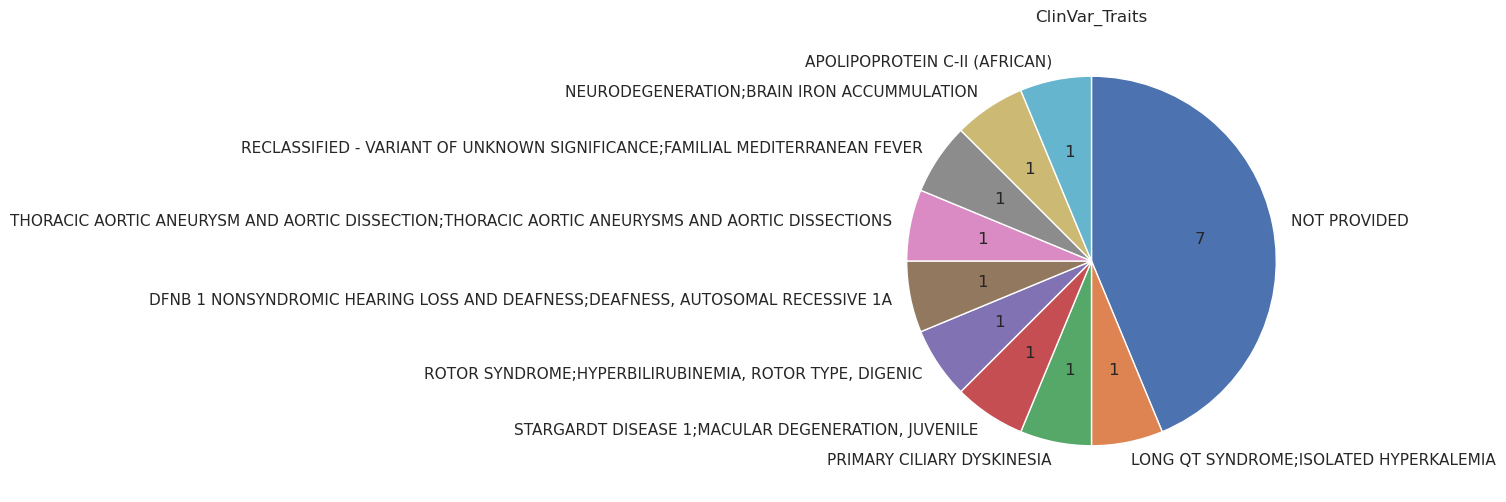

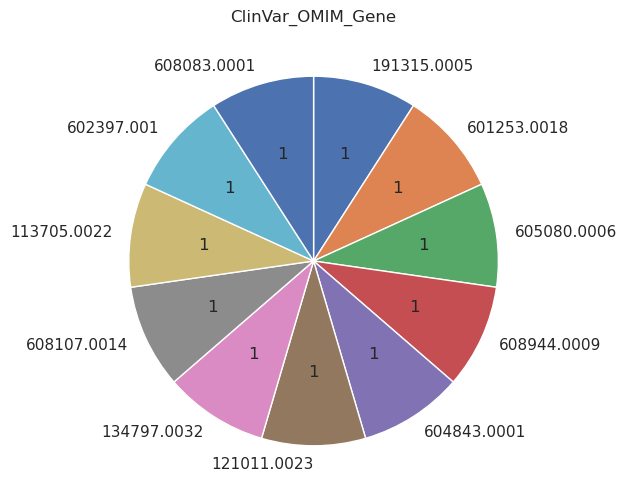

In [79]:
clin_cols = ['OMIM', 'ClinVar_ClinicalSignificance', 'ClinVar_GeneSymbol', 'ClinVar_Traits', 'ClinVar_OMIM_Gene']

def absolute_numbers(val):
    absolute = int(val / 100. * counts.sum())
    return f'{absolute}'

for i in clin_cols:
    counts = merged[merged[i] != 'None'][i].value_counts()
    plt.figure(figsize=(8, 6))
    counts.plot.pie(autopct=absolute_numbers, startangle=90, counterclock=False)
    plt.ylabel('')  # Hide the y-label
    plt.title(i)
    plt.show()

In [80]:
hs = []
for i in CHROMOSOMES_ALL:
    t = pd.read_csv('results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
h

chr       pos ref alt       MAF       NRC  NRC_BC        r2  r2_BC  \
0        1    784860   T   C  0.959400  1.000000     183  0.997843    185   
1        1    785910   G   C  0.025452  0.750000       8  0.842741    184   
2        1    788538   G   A  0.086260  0.973684      38  0.971634    186   
3        1    818725   C   T  0.023735  0.875000       8  0.853221    185   
4        1    819249   A   G  0.025074  0.875000       8  0.857605    186   
...    ...       ...  ..  ..       ...       ...     ...       ...    ...   
12132   22  50749854   G   A  0.093138  0.956522      23  0.983148    186   
12133   22  50749890   T   G  0.025043  1.000000       5  0.999999    185   
12134   22  50770140   G   T  0.261949  0.958763      97  0.950049    186   
12135   22  50777904   G   A  0.041119  0.944444      18  0.974504    185   
12136   22  50779526   G   A  0.088980  1.000000      17  1.000000    186   

       ccd_homref  ccd_homref_BC   ccd_het  ccd_het_BC  ccd_homalt  \
0        1.000000              2  1.000000          20         1.0   
1        1.000000            176  0.750000           8        -9.0   
2        1.000000            148  0.970588          34         1.0   
3        1.000000            177  0.875000           8        -9.0   
4        1.000000            178  0.875000           8        -9.0   
...           ...            ...       ...         ...         ...   
12132    1.000000            163  0.952381          21         1.0   
12133    1.000000            180  1.000000           5        -9.0   
12134    0.967391             92  0.987805          82         1.0   
12135    0.994048            168  1.000000          17        -9.0   
12136    1.000000            169  1.000000          14         1.0   

       ccd_homalt_BC  
0                163  
1                  0  
2                  4  
3                  0  
4                  0  
...              ...  
12132              2  
12133              0  
12134             12  
12135              0  
12136              3  

[708100 rows x 15 columns]

In [84]:
window = 1e5
means = []
for snp in range(len(merged)):
    means.append(lcwgsus.plot_imputation_metric_in_region(h, merged.iloc[snp, 0], merged.iloc[snp, 1], window = window, show_fig = False))

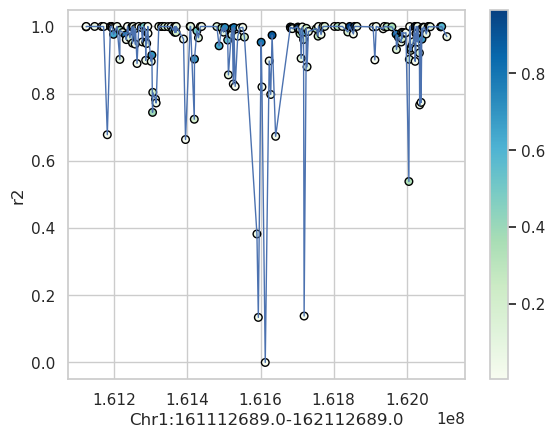

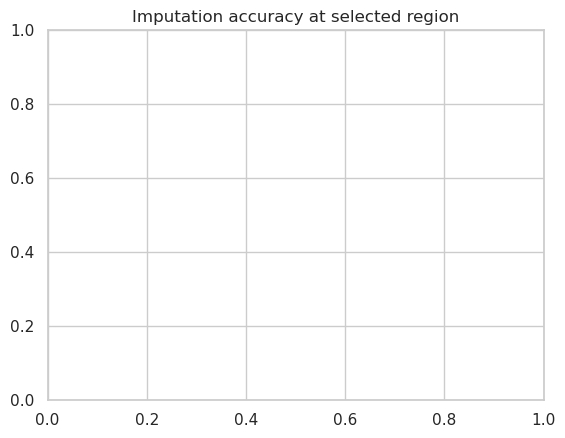

In [86]:
means = np.array(means)
means.argmin()
lcwgsus.plot_imputation_metric_in_region(h, merged.iloc[58, 0], merged.iloc[58, 1], window = 1e6, show_fig = True)

means.sort()